In [1]:
import fiftyone as fo
from fiftyone import ViewField as F
from tqdm import tqdm
import numpy as np

In [2]:
dataset_name = "mcity_fisheye_3_months"
dataset = fo.load_dataset(dataset_name)

vru_labels = ["skater",
                "child",
                "bicycle",
                "bicyclist",
                "cyclist",
                "bike",
                "rider",
                "motorcycle",
                "motorcyclist",
                "pedestrian",
                "person",
                "walker",
                "jogger",
                "runner",
                "skateboarder",
                "scooter",
                "delivery driver"]

vehicle_labels = ["vehicle",
                "car",
                "bus",
                "truck",
                "taxi",
                "van",
                "pickup truck",
                "trailer",
                "emergency vehicle",]

In [5]:
#Get fields of zero shot model predictions
pred_fields = []
dataset_schema = dataset.get_field_schema()
for field in dataset_schema:
    if "pred_" in field:
        pred_fields.append(field)

conditions = [
    (F(f"{field}") != None) &          # Field exists
    (F(f"{field}.detections") != []) &  # Field has detections
    F(f"{field}.detections.label").contains(vru_labels)  # Detections include "cat" or "dog"
    for field in pred_fields
]

view = dataset.match(F.any(conditions))

In [7]:
classes = dataset.distinct("%s.detections.label" % pred_fields[0])
print(classes)

['bicycle', 'bicyclist', 'bike', 'bus', 'car', 'child', 'cyclist', 'emergency vehicle', 'jogger', 'motorcycle', 'motorcyclist', 'pedestrian', 'person', 'pickup truck', 'rider', 'runner', 'scooter', 'skateboarder', 'skater', 'taxi', 'trailer', 'truck', 'van', 'vehicle', 'walker']


In [211]:
for field in tqdm(pred_fields, desc="generating view"):
    view = view.filter_labels(f"{field}.detections",F("label").is_in(vru_labels), only_matches=False)
n_samples = len(view)

generating view: 100%|██████████| 10/10 [00:00<00:00, 431.64it/s]


In [212]:
samples_detections = [] # List of lists of list [model][sample][detections]
for field in tqdm(pred_fields, desc = "Getting detection values"):
    field_detections = view.values(f"{field}.detections")  # list of lists of detections per sample
    samples_detections.append(field_detections)

Getting detection values: 100%|██████████| 10/10 [01:34<00:00,  9.43s/it]


In [220]:
# Cleanup previous runs
v51_tag = "vru_overlap"

for i in tqdm(range(n_samples)):
    for j in range(len(pred_fields)):
        detections = samples_detections[j][i]
        for k in range(len(detections)):
            try:
                samples_detections[j][i][k].tags.remove(v51_tag)
            except:
                pass
            if len(samples_detections[j][i][k].tags) > 0:
                print(samples_detections[j][i][k].tags)

100%|██████████| 49298/49298 [00:02<00:00, 23667.00it/s]


In [214]:
def calculate_iou(box1, box2):
    # box format: [minx, miny, width, height] normalized between [0,1]
    x1_min, y1_min, w1, h1 = box1
    x2_min, y2_min, w2, h2 = box2
    x1_max, y1_max = x1_min + w1, y1_min + h1
    x2_max, y2_max = x2_min + w2, y2_min + h2

    # Calculate the intersection box
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    if inter_x_min < inter_x_max and inter_y_min < inter_y_max:
        inter_area = (inter_x_max - inter_x_min) * (inter_y_max - inter_y_min)
    else:
        inter_area = 0

    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def calculcate_size(box):
    return box[2] * box[3]

In [ ]:
agreement_threshold = 3
iou_threshold = 0.5

max_bbox_size = 0.01 # VRUs are typically small

max_detections_per_model = max(len(detections) for model_detections in samples_detections for detections in model_detections)

v51_tag = "vru_overlap"
n_bboxes_agreed = 0
n_samples_agreed = 0
n_unique_vru = 0

for sample_index in tqdm(range(n_samples)):  # For each sample
    unique_vru_detections_set = set()
    all_bboxes = []                 # List of all bounding box detections per sample
    bbox_model_indices = []         # Track which model each bounding box belongs to
    bbox_detection_indices = []     # Track the index of each detection in the model's list

    for model_index, model_detections in enumerate(samples_detections):
        for detection_index, det in enumerate(model_detections[sample_index]):
            all_bboxes.append(det.bounding_box)
            bbox_model_indices.append(model_index)
            bbox_detection_indices.append(detection_index)
    n_bboxes = len(all_bboxes)
    
    involved_models = [set()] * n_bboxes    # Track all models involved in successful overlaps
    involved_bboxes = [set()] * n_bboxes    # Track all bboxes involved in successful overlaps


    if n_bboxes == 0:
        continue

    involved_models_matrix = np.full((n_bboxes, n_bboxes), -1)
    bbox_ids_matrix = np.full((n_bboxes, n_bboxes), -1)
    for a in range(n_bboxes):
        for b in range(a + 1, n_bboxes):
            iou = calculate_iou(all_bboxes[a], all_bboxes[b])
            # Only compare detections of small bounding boxes
            if max_bbox_size and calculcate_size(all_bboxes[a]) <= max_bbox_size and calculcate_size(all_bboxes[b]) <= max_bbox_size:
                # Only compare detections of high IoU scores
                if iou > iou_threshold:
                    involved_models_matrix[a, b] = bbox_model_indices[b]    # Store model index that was compared to
                    involved_models_matrix[b, a] = bbox_model_indices[a]
                    involved_models_matrix[a, a] = bbox_model_indices[a]    # Trick to also store the model itself, as the diagonal is not used (b = a+1, symmetry)
                    involved_models_matrix[b, b] = bbox_model_indices[b]

                    bbox_ids_matrix[a, b] = b                                 # Store detection indices to get involved bounding_boxes
                    bbox_ids_matrix[b, a] = a
                    bbox_ids_matrix[a, a] = a
                    bbox_ids_matrix[b, b] = b
                    

     # Get number of involved models by finding unique values in rows
    # "-1" ist not an involved model
    involved_models = [np.unique(row) for row in involved_models_matrix]
    for index in range(len(involved_models)):
        involved_models[index] = involved_models[index][involved_models[index] != -1]

    # Get list of involved bounding box indices
    involved_bboxes = [np.unique(row) for row in bbox_ids_matrix]
    for index in range(len(bbox_ids_matrix)):
        involved_bboxes[index] = involved_bboxes[index][involved_bboxes[index] != -1]

    #Checking that all arrays have the same lengths
    assert len(all_bboxes) == len(bbox_model_indices) == len(bbox_detection_indices) == len(involved_models), "Array lengths should be identical"

    for index in range(n_bboxes):
        bbox_indices = involved_bboxes[index]
        model_indices = involved_models[index]

        all_connected_boxes = bbox_indices

        if len(model_indices) >= agreement_threshold:
            # Get all involved bounding boxe indices
            for bbox_index in bbox_indices:
                connected_bboxes = involved_bboxes[bbox_index]
                all_connected_boxes = np.unique(np.concatenate((all_connected_boxes, connected_bboxes))) 
            unique_detection_id = np.min(all_connected_boxes)

            # If bounding box has not been processed yet
            if unique_detection_id not in unique_vru_detections_set:
                unique_vru_detections_set.add(unique_detection_id)
                # Set V51 tag to all connected boxes
                for bbox_index in all_connected_boxes:
                    model_index = bbox_model_indices[bbox_index]
                    det_index = bbox_detection_indices[bbox_index]
                    if v51_tag not in samples_detections[model_index][sample_index][det_index].tags:
                        samples_detections[model_index][sample_index][det_index].tags.append(v51_tag)
                        samples_detections[model_index][sample_index][det_index]["vru_id"] = unique_detection_id
                    n_bboxes_agreed += 1
    
    if len(unique_vru_detections_set) > 0:
        n_samples_agreed += 1
        n_unique_vru += len(unique_vru_detections_set)

print(f"Found {n_unique_vru} unique detections in {n_samples_agreed} samples. Based on {n_bboxes_agreed} total detections with {agreement_threshold} or more overlapping detections.")

100%|██████████| 49298/49298 [00:36<00:00, 1353.29it/s]

Found 25061 unique detections in 19906 samples. Based on 175219 total detections with 3 or more overlapping detections.


In [222]:
for field, field_detections in tqdm(zip(pred_fields,samples_detections), desc = "Saving results to dataset", total=len(pred_fields)):
    view.set_values(field + ".detections", field_detections) 

Saving results to dataset: 100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


In [223]:
# Analyze bounding_box size distribution
view_vru = view.select_labels(tags=v51_tag)
print(len(view_vru))

19906


Getting bounding boxes values: 100%|██████████| 10/10 [00:42<00:00,  4.21s/it]


In [224]:
try:
    dataset.delete_sample_field("n_vru")
except:
    pass

for sample in view_vru.iter_samples(progress=True, autosave=True):
    n_vrus_set = set()
    for field in pred_fields:
        detections = sample[field].detections
        n_vrus_set.update(d["vru_id"] for d in detections)
    sample["n_vru"] = len(n_vrus_set)

 100% |█████████████| 19906/19906 [53.3s elapsed, 0s remaining, 375.2 samples/s]      


In [ ]:
bbox_areas = []
for field in tqdm(pred_fields, desc = "Getting bounding boxes values"):
    field_detections = view_vru.values(f"{field}.detections")  # list of lists of detections per sample
    for detections in field_detections:
        for detection in detections:
            bbox_area = float(detection["bounding_box"][2] * detection["bounding_box"][3])
            bbox_areas.append(bbox_area)

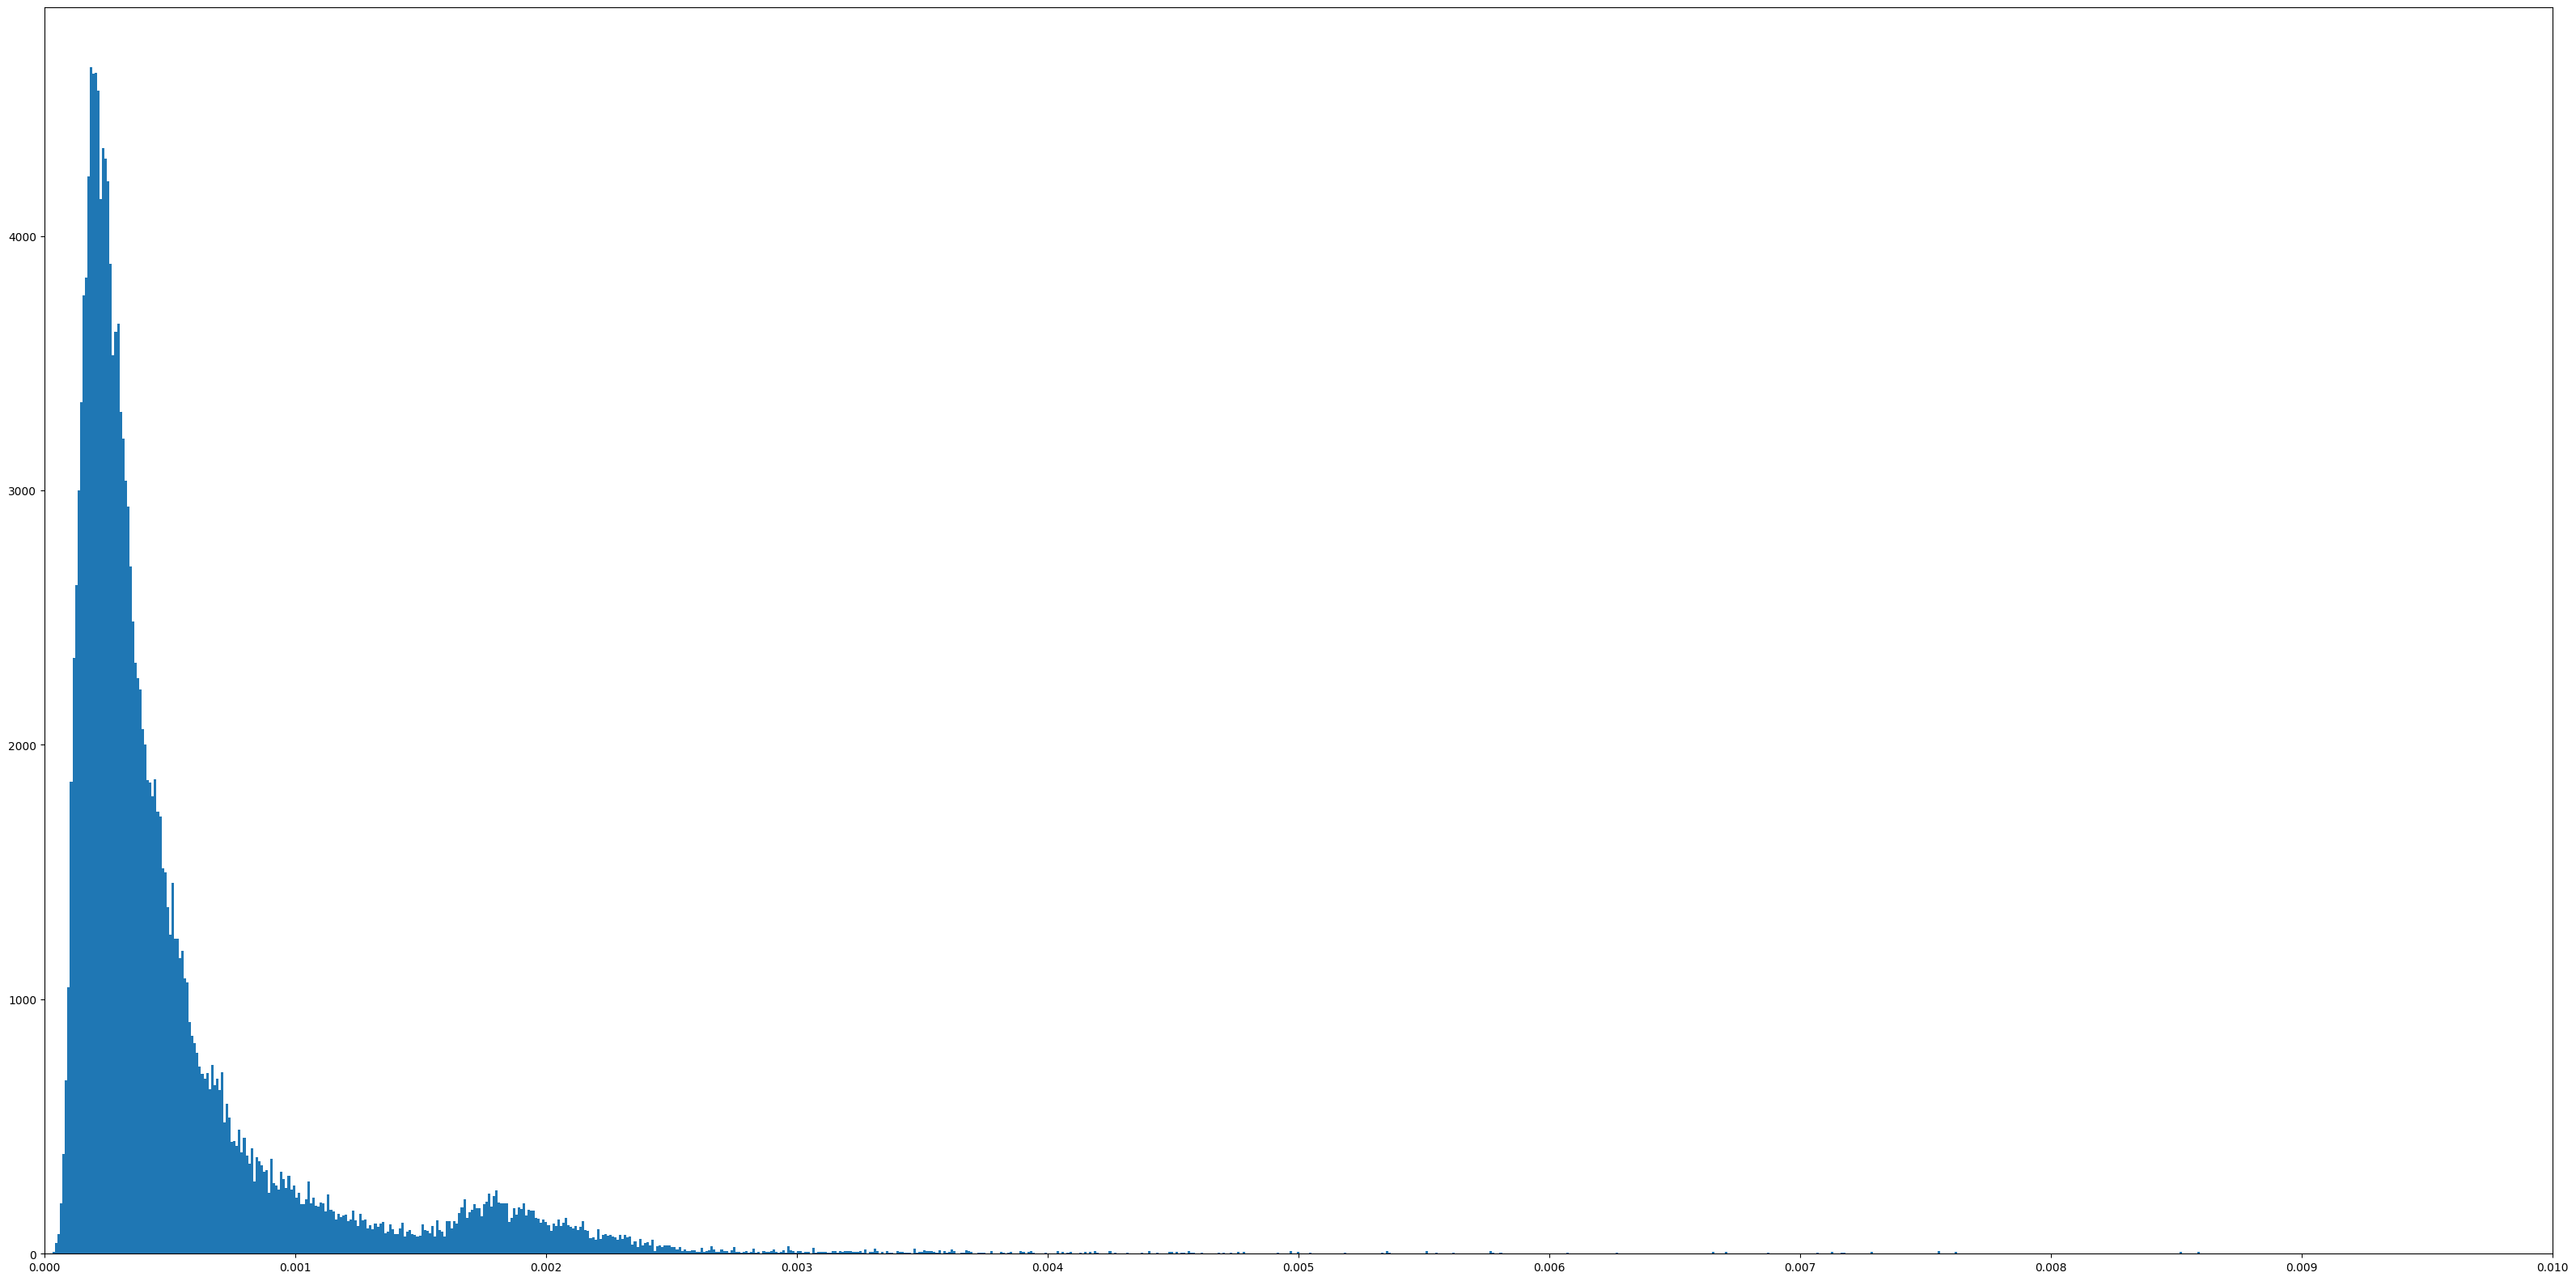

In [225]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(40,20))
ax.hist(bbox_areas, bins=1000)

ax.xaxis.set_major_locator(plt.MultipleLocator(0.001))
plt.xlim(0, 0.01)

plt.show() 